# compare MSE

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA

from tqdm import tqdm

# load the datasets

In [2]:
y_raw = list(range(1300,1401))
orig_ds = []
denois_ds = []
for y in y_raw:
    orig_row = [y-1299]
    denois_row = [y-1299]
    df = pd.read_table(f'.\TE 101 denoised\TE 101 denoised\TE_denoised_{y}.txt')
    orig_row.extend(df.signal)
    denois_row.extend(df.smoothed_signal)
    orig_ds.append(orig_row)
    denois_ds.append(denois_row)

orig_df = pd.DataFrame(orig_ds, columns=['y'] + [f"covar_{i}" for i in range(1, 10_001)])
denois_df = pd.DataFrame(denois_ds, columns=['y'] + [f"covar_{i}" for i in range(1, 10_001)])
print(orig_df.shape, denois_df.shape)

(101, 10001) (101, 10001)


In [3]:
orig_df

,y,covar_1,covar_2,covar_3,covar_4,covar_5,covar_6,covar_7,covar_8,covar_9,...,covar_9991,covar_9992,covar_9993,covar_9994,covar_9995,covar_9996,covar_9997,covar_9998,covar_9999,covar_10000
0,1,0.094030,0.093023,0.092140,0.091346,0.090607,0.089921,0.089290,0.088711,0.088193,...,0.928475,0.928521,0.928566,0.928610,0.928653,0.928695,0.928736,0.928776,0.928815,0.928852
1,2,0.093972,0.093029,0.092084,0.091178,0.090374,0.089710,0.089140,0.088569,0.088005,...,0.927875,0.927868,0.927862,0.927858,0.927854,0.927851,0.927850,0.927849,0.927850,0.927852
2,3,0.093837,0.092869,0.091922,0.091056,0.090282,0.089569,0.088922,0.088366,0.087838,...,0.928875,0.928887,0.928898,0.928908,0.928917,0.928924,0.928930,0.928934,0.928937,0.928940
3,4,0.093701,0.092776,0.091857,0.090968,0.090130,0.089380,0.088752,0.088199,0.087632,...,0.927960,0.927987,0.928014,0.928043,0.928072,0.928101,0.928132,0.928163,0.928194,0.928226
4,5,0.093579,0.092674,0.091762,0.090847,0.089981,0.089246,0.088612,0.087991,0.087418,...,0.928869,0.928851,0.928832,0.928811,0.928790,0.928767,0.928744,0.928721,0.928696,0.928672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,0.079700,0.079353,0.079022,0.078654,0.078216,0.077714,0.077176,0.076624,0.076068,...,0.932126,0.932150,0.932172,0.932192,0.932210,0.932226,0.932241,0.932253,0.932263,0.932272
97,98,0.079530,0.079183,0.078854,0.078493,0.078059,0.077567,0.077067,0.076546,0.075958,...,0.931780,0.931819,0.931857,0.931893,0.931929,0.931963,0.931997,0.932029,0.932060,0.932090
98,99,0.079314,0.078921,0.078561,0.078220,0.077843,0.077399,0.076899,0.076374,0.075831,...,0.931621,0.931652,0.931681,0.931711,0.931739,0.931767,0.931795,0.931821,0.931847,0.931872
99,100,0.079059,0.078652,0.078349,0.078054,0.077671,0.077215,0.076727,0.076222,0.075699,...,0.931779,0.931770,0.931760,0.931750,0.931739,0.931727,0.931715,0.931702,0.931689,0.931676


In [4]:
# build a correlation matrix for the original data
orig_corr = orig_df[orig_df.columns[1:]].corr()
denois_corr = denois_df[denois_df.columns[1:]].corr()

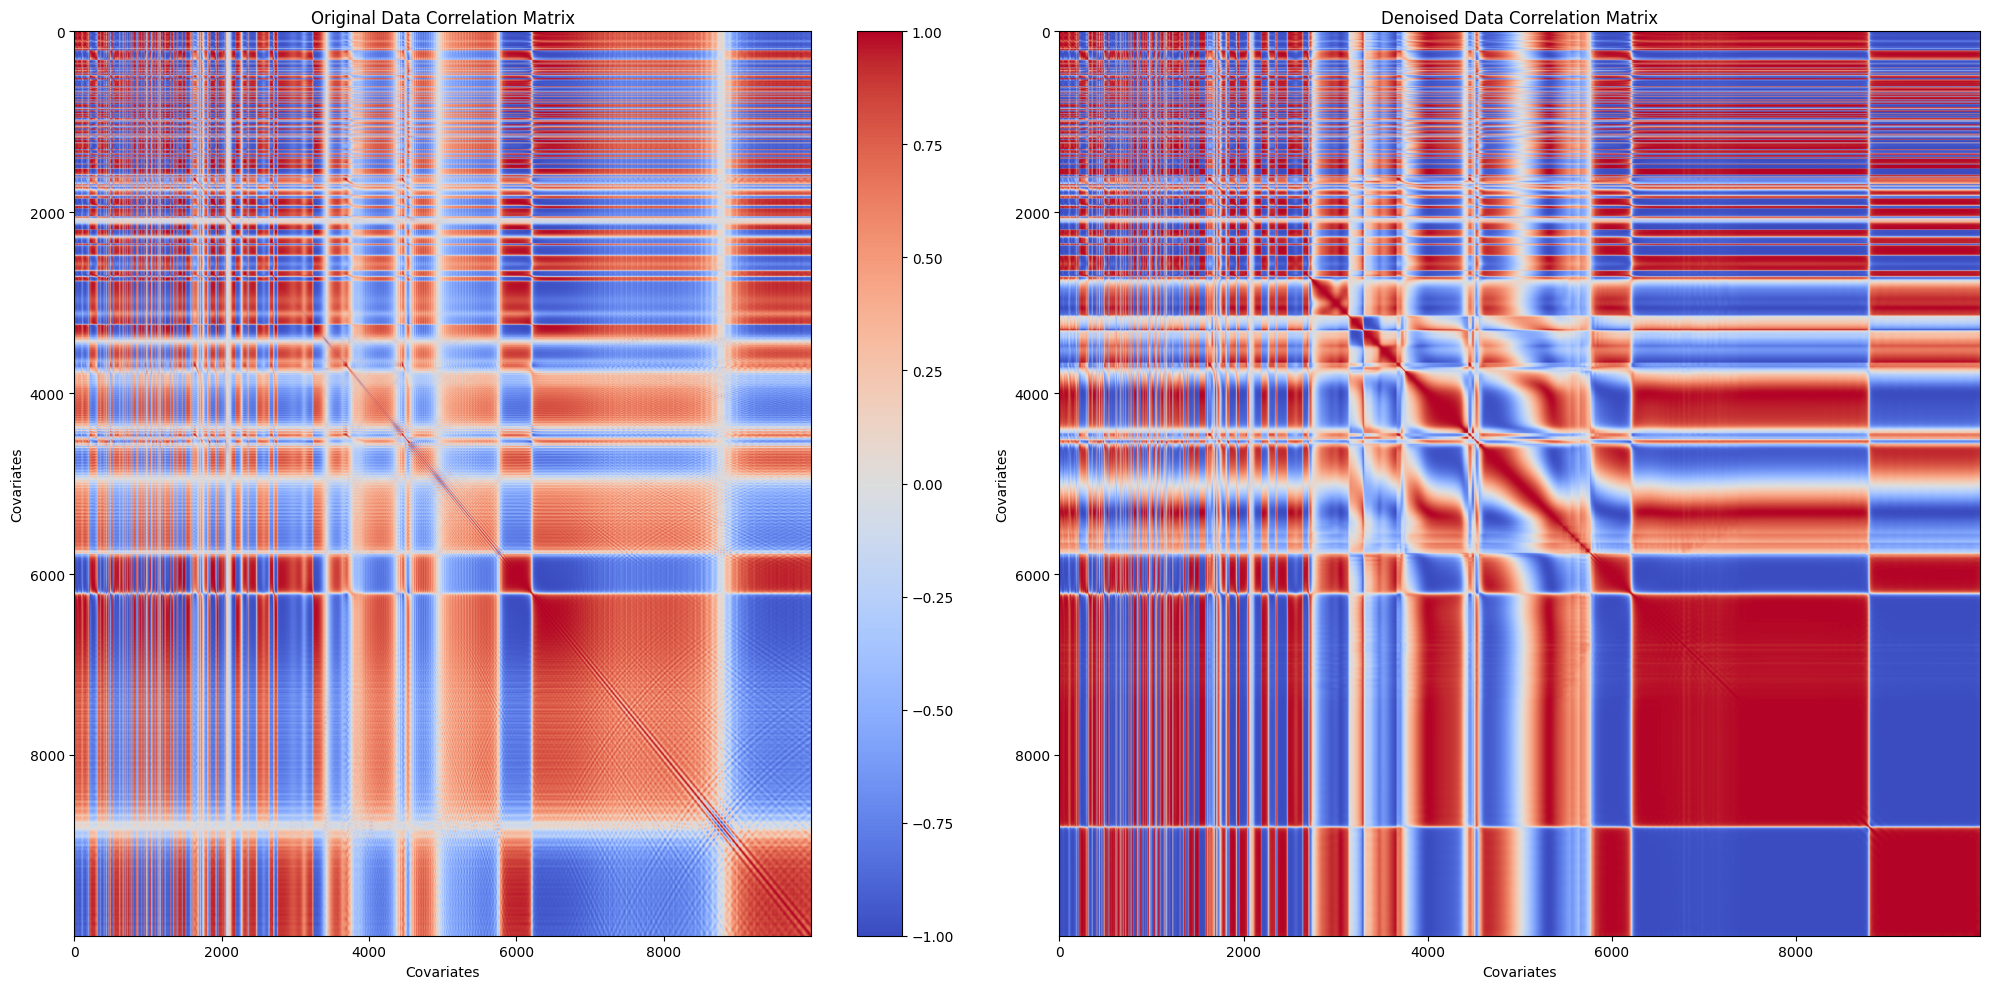

In [5]:
# create 2 subplots side by side horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# plot the original data correlation matrix
im1 = ax1.imshow(orig_corr, cmap='coolwarm', aspect='auto', vmax=1, vmin=-1)
fig.colorbar(im1, ax=ax1)
ax1.set_title('Original Data Correlation Matrix')
ax1.set_xlabel('Covariates')
ax1.set_ylabel('Covariates')
# plot the denoised data correlation matrix
im2 = ax2.imshow(denois_corr, cmap='coolwarm', aspect='auto', vmax=1, vmin=-1)
# fig.colorbar(im2, ax=ax2)
ax2.set_title('Denoised Data Correlation Matrix')
ax2.set_xlabel('Covariates')
ax2.set_ylabel('Covariates')
plt.tight_layout()
plt.show()

In [6]:
orig_err_list = []
denois_err_list = []
# for each covariate fit a single variable linear regression model with intercept and obtain the MSE and R2
for var in tqdm(range(1,10001)):
    vname = f"covar_{var}"
    orig_datum = {"covar": vname, "mse": None, "r2": None}
    denois_datum = {"covar": vname, "mse": None, "r2": None}
    orig_y = orig_df['y']
    orig_x = orig_df[vname]
    denois_y = denois_df['y']
    denois_x = denois_df[vname]
    # fit the model
    model = LinearRegression(fit_intercept=True)
    model.fit(orig_x.values.reshape(-1, 1), orig_y)
    # make predictions
    orig_y_pred = model.predict(orig_x.values.reshape(-1, 1))
    # calculate MSE and R2
    orig_datum["mse"] = mean_squared_error(orig_y, orig_y_pred)
    orig_datum["r2"] = r2_score(orig_y, orig_y_pred)
    # append to the list
    orig_err_list.append(orig_datum)
    # fit the model
    model = LinearRegression(fit_intercept=True)
    model.fit(denois_x.values.reshape(-1, 1), denois_y)
    # make predictions
    denois_y_pred = model.predict(denois_x.values.reshape(-1, 1))
    # calculate MSE and R2
    denois_datum["mse"] = mean_squared_error(denois_y, denois_y_pred)
    denois_datum["r2"] = r2_score(denois_y, denois_y_pred)
    # append to the list
    denois_err_list.append(denois_datum)
orig_err_df = pd.DataFrame(orig_err_list)
denois_err_df = pd.DataFrame(denois_err_list)


100%|██████████| 10000/10000 [01:51<00:00, 90.06it/s]


In [7]:
orig_err_df.sort_values(by='mse', ascending=True)

,covar,mse,r2
389,covar_390,0.185567,9.997817e-01
897,covar_898,0.781449,9.990806e-01
250,covar_251,0.837777,9.990144e-01
828,covar_829,0.857565,9.989911e-01
241,covar_242,0.874447,9.989712e-01
...,...,...,...
2100,covar_2101,849.993499,7.648308e-06
4495,covar_4496,849.993966,7.099014e-06
439,covar_440,849.994244,6.771319e-06
8811,covar_8812,849.998909,1.283327e-06


In [8]:
denois_err_df.sort_values(by='mse', ascending=True)

,covar,mse,r2
389,covar_390,0.234435,9.997242e-01
8393,covar_8394,0.287783,9.996614e-01
8392,covar_8393,0.288610,9.996605e-01
8394,covar_8395,0.288666,9.996604e-01
8391,covar_8392,0.291287,9.996573e-01
...,...,...,...
3768,covar_3769,849.997099,3.413476e-06
4407,covar_4408,849.998009,2.342819e-06
997,covar_998,849.999457,6.387205e-07
5024,covar_5025,849.999842,1.861733e-07


In [9]:
orig_corr

,covar_1,covar_2,covar_3,covar_4,covar_5,covar_6,covar_7,covar_8,covar_9,covar_10,...,covar_9991,covar_9992,covar_9993,covar_9994,covar_9995,covar_9996,covar_9997,covar_9998,covar_9999,covar_10000
covar_1,1.000000,0.997394,0.994470,0.992500,0.990332,0.989709,0.988663,0.988530,0.988395,0.988220,...,-0.923370,-0.924054,-0.924537,-0.924870,-0.924934,-0.924786,-0.924440,-0.923818,-0.922985,-0.921940
covar_2,0.997394,1.000000,0.997100,0.994725,0.991830,0.990579,0.988811,0.988283,0.988410,0.988707,...,-0.925375,-0.926326,-0.927066,-0.927656,-0.927967,-0.928052,-0.927932,-0.927515,-0.926872,-0.926006
covar_3,0.994470,0.997100,1.000000,0.997215,0.994027,0.991929,0.989719,0.988708,0.988517,0.989020,...,-0.925251,-0.925930,-0.926388,-0.926697,-0.926738,-0.926553,-0.926168,-0.925503,-0.924614,-0.923514
covar_4,0.992500,0.994725,0.997215,1.000000,0.996960,0.994280,0.991603,0.990020,0.989118,0.989239,...,-0.925592,-0.925965,-0.926122,-0.926128,-0.925868,-0.925386,-0.924703,-0.923750,-0.922583,-0.921213
covar_5,0.990332,0.991830,0.994027,0.996960,1.000000,0.997033,0.993595,0.991226,0.989751,0.989031,...,-0.924781,-0.924959,-0.924919,-0.924732,-0.924286,-0.923625,-0.922764,-0.921645,-0.920320,-0.918805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
covar_9996,-0.924786,-0.928052,-0.926553,-0.925386,-0.923625,-0.921338,-0.917609,-0.915535,-0.917073,-0.917174,...,0.991386,0.994420,0.996825,0.998577,0.999643,1.000000,0.999638,0.998551,0.996725,0.994183
covar_9997,-0.924440,-0.927932,-0.926168,-0.924703,-0.922764,-0.920374,-0.916594,-0.914554,-0.916239,-0.916419,...,0.987539,0.991242,0.994333,0.996785,0.998563,0.999638,1.000000,0.999637,0.998537,0.996713
covar_9998,-0.923818,-0.927515,-0.925503,-0.923750,-0.921645,-0.919168,-0.915356,-0.913360,-0.915189,-0.915452,...,0.982991,0.987355,0.991124,0.994273,0.996759,0.998551,0.999637,1.000000,0.999631,0.998532
covar_9999,-0.922985,-0.926872,-0.924614,-0.922583,-0.920320,-0.917767,-0.913929,-0.911976,-0.913938,-0.914284,...,0.977725,0.982742,0.987183,0.991024,0.994217,0.996725,0.998537,0.999631,1.000000,0.999634


In [10]:
corr_thresh = 0.2

orig_keep_covar = set()
for covar in tqdm(orig_err_df.sort_values(by='mse', ascending=True).covar):
    for j,my_corr in zip(orig_corr.index,orig_corr[covar]):
        if (my_corr * my_corr) >= corr_thresh and j in orig_keep_covar:
            break
    else:
        orig_keep_covar.add(covar)
print(len(orig_keep_covar), len(orig_err_df))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:10<00:00, 955.19it/s]

77 10000


In [11]:
denois_keep_covar = set()
for covar in tqdm(denois_err_df.sort_values(by='mse', ascending=True).covar):
    for j,my_corr in zip(denois_corr.index,denois_corr[covar]):
        if (my_corr * my_corr) >= corr_thresh and j in denois_keep_covar:
            break
    else:
        denois_keep_covar.add(covar)
print(len(denois_keep_covar), len(denois_err_df))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:09<00:00, 1049.48it/s]

29 10000


In [12]:
# calculate the mse and r2 for the original data and denoised data using all the selected covariates
orig_y = orig_df['y']
denois_y = denois_df['y']
orig_x = orig_df[list(orig_keep_covar)]
denois_x = denois_df[list(denois_keep_covar)]
# fit the model
orig_model = LinearRegression(fit_intercept=True)
orig_model.fit(orig_x, orig_y)
# make predictions
orig_y_pred = orig_model.predict(orig_x)
# calculate MSE and R2
orig_mse = mean_squared_error(orig_y, orig_y_pred)
orig_r2 = r2_score(orig_y, orig_y_pred)
# fit the model
denois_model = LinearRegression(fit_intercept=True)
denois_model.fit(denois_x, denois_y)
# make predictions
denois_y_pred = denois_model.predict(denois_x)
# calculate MSE and R2
denois_mse = mean_squared_error(denois_y, denois_y_pred)
denois_r2 = r2_score(denois_y, denois_y_pred)
print(f"Original Data MSE: {orig_mse}, R2: {orig_r2}")
print(f"Denoised Data MSE: {denois_mse}, R2: {denois_r2}")

Original Data MSE: 0.0006432755741700354, R2: 0.9999992432052068
Denoised Data MSE: 0.02356699501882597, R2: 0.9999722741235073


# identify the effect on MSE when including more covariates

In [13]:
# build a mapping for each of the selected covariates to the single variant mse
orig_mse_map = {}
for covar in orig_keep_covar:
    orig_mse_map[covar] = orig_err_df[orig_err_df.covar == covar].mse.values[0]

cur_model = []
model_mse_list = []
for _ in range(25):
    # find the covariate with the lowest mse from the map and remove it
    min_mse = min(orig_mse_map.values())
    min_covar = [k for k, v in orig_mse_map.items() if v == min_mse][0]
    # append to the list
    cur_model.append(min_covar)
    # remove from the map
    del orig_mse_map[min_covar]
    # calculate the mse for the current model
    model = LinearRegression(fit_intercept=True)
    model.fit(orig_x[cur_model], orig_y)
    # make predictions
    y_pred = model.predict(orig_x[cur_model])
    # calculate MSE and R2
    model_mse = mean_squared_error(orig_y, y_pred)
    model_r2 = r2_score(orig_y, y_pred)
    datum = {"num_covar": len(cur_model), "mse": model_mse, "r2": model_r2, "added_covar": min_covar}
    model_mse_list.append(datum)
model_mse_df = pd.DataFrame(model_mse_list)
model_mse_df

,num_covar,mse,r2,added_covar
0,1,0.185567,0.999782,covar_390
1,2,0.136164,0.999840,covar_366
2,3,0.096394,0.999887,covar_1175
3,4,0.096367,0.999887,covar_3646
4,5,0.096163,0.999887,covar_8650
5,6,0.095739,0.999887,covar_4856
6,7,0.095706,0.999887,covar_5032
7,8,0.094465,0.999889,covar_4899
8,9,0.087962,0.999897,covar_4405
9,10,0.087027,0.999898,covar_1744


In [14]:
# now repeat with the denoised data
denois_mse_map = {}
for covar in denois_keep_covar:
    denois_mse_map[covar] = denois_err_df[denois_err_df.covar == covar].mse.values[0]
cur_model = []
model_mse_list = []

for _ in range(25):
    # find the covariate with the lowest mse from the map and remove it
    min_mse = min(denois_mse_map.values())
    min_covar = [k for k, v in denois_mse_map.items() if v == min_mse][0]
    # append to the list
    cur_model.append(min_covar)
    # remove from the map
    del denois_mse_map[min_covar]
    # calculate the mse for the current model
    model = LinearRegression(fit_intercept=True)
    model.fit(denois_x[cur_model], denois_y)
    # make predictions
    y_pred = model.predict(denois_x[cur_model])
    # calculate MSE and R2
    model_mse = mean_squared_error(denois_y, y_pred)
    model_r2 = r2_score(denois_y, y_pred)
    datum = {"num_covar": len(cur_model), "mse": model_mse, "r2": model_r2, "added_covar": min_covar}
    model_mse_list.append(datum)
denoised_model_mse_df = pd.DataFrame(model_mse_list)
denoised_model_mse_df

,num_covar,mse,r2,added_covar
0,1,0.234435,0.999724,covar_390
1,2,0.194410,0.999771,covar_4918
2,3,0.186573,0.999781,covar_2745
3,4,0.138236,0.999837,covar_4443
4,5,0.138114,0.999838,covar_2716
5,6,0.135371,0.999841,covar_3728
6,7,0.044499,0.999948,covar_488
7,8,0.043346,0.999949,covar_2070
8,9,0.042882,0.999950,covar_4521
9,10,0.039908,0.999953,covar_5725


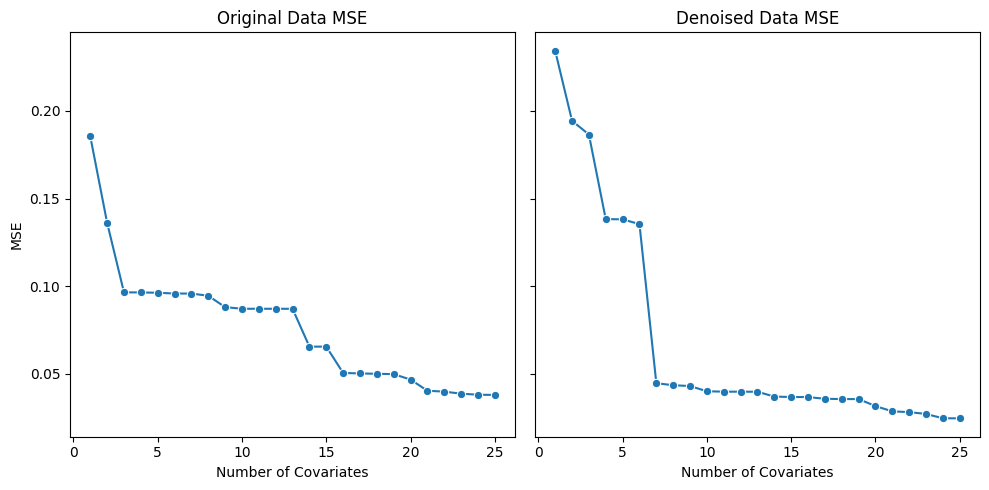

In [15]:
# build 2 side by side line plots for the original and denoised data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# plot the original data mse
sns.lineplot(data=model_mse_df, x='num_covar', y='mse', ax=ax1, marker='o')
ax1.set_title('Original Data MSE')
ax1.set_xlabel('Number of Covariates')
ax1.set_ylabel('MSE')
# plot the denoised data mse
sns.lineplot(data=denoised_model_mse_df, x='num_covar', y='mse', ax=ax2, marker='o')
ax2.set_title('Denoised Data MSE')
ax2.set_xlabel('Number of Covariates')
ax2.set_ylabel('MSE')
plt.tight_layout()
plt.show()

# try lasso

In [16]:
viable_alphas = np.logspace(-4, 0, 10)
alpha_mse_list = []
for alpha in tqdm(viable_alphas):
    # fit the model
    model = Lasso(alpha=alpha, fit_intercept=True, max_iter=100_000)
    model.fit(orig_x, orig_y)
    # make predictions
    y_pred = model.predict(orig_x)
    # calculate MSE and R2
    model_mse = mean_squared_error(orig_y, y_pred)
    model_r2 = r2_score(orig_y, y_pred)
    datum = {"alpha": alpha, "mse": model_mse, "r2": model_r2}
    alpha_mse_list.append(datum)
alpha_mse_df = pd.DataFrame(alpha_mse_list)
# orig_lasso_model = Lasso(alpha=0.001, fit_intercept=True, max_iter=100_000)
# orig_x = orig_df[orig_df.columns[1:]]
# orig_y = orig_df['y']
# orig_lasso_model.fit(orig_x, orig_y)
# # make predictions
# orig_y_pred = orig_lasso_model.predict(orig_x)
# # calculate MSE and R2
# orig_lasso_mse = mean_squared_error(orig_y, orig_y_pred)
# orig_lasso_r2 = r2_score(orig_y, orig_y_pred)
# print(f"Original Data Lasso MSE: {orig_lasso_mse}, R2: {orig_lasso_r2}")
# print(f"num non-zero coefficients: {np.sum(orig_lasso_model.coef_ != 0)}")

100%|██████████| 10/10 [00:00<00:00, 70.61it/s]


# read new data from xlsx

In [17]:
new_data = pd.read_excel("Ti_Te_2D.xlsx", header=None)
new_data

,0,1,2
0,1,0.22732,0.80846
1,2,0.22687,0.80828
2,3,0.22638,0.80804
3,4,0.22595,0.80794
4,5,0.22559,0.80762
...,...,...,...
96,97,0.18635,0.78984
97,98,0.18605,0.78955
98,99,0.18570,0.78942
99,100,0.18535,0.78922


In [18]:
x = new_data[0]
y1 = new_data[1]
y2 = new_data[2]

y1_list = []
y2_list = []
# now we want to compute the leave one out MSE for a linear regression model
# fit the model
for i in range(len(x)):
    x_train = np.delete(x, i)
    y_train = np.delete(y1, i)
    x_test = x[i]
    y_test = y1[i]
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train.reshape(-1, 1), y_train)
    # make predictions
    y_pred = model.predict(np.array([[x_test]]))
    # calculate MSE and R2 on the training data
    train_mse = mean_squared_error(y_train, model.predict(x_train.reshape(-1, 1)))
    train_r2 = r2_score(y_train, model.predict(x_train.reshape(-1, 1)))
    # calculate the SE for the test point
    test_se = (y_test-y_pred[0])**2
    datum = {"x": x_test, "y": y_test, "train_mse": train_mse, "train_r2": train_r2, "test_se": test_se}
    y1_list.append(datum)

    # now do the same for y2
    x_train = np.delete(x, i)
    y_train = np.delete(y2, i)
    x_test = x[i]
    y_test = y2[i]
    model = LinearRegression(fit_intercept=True)
    model.fit(x_train.reshape(-1, 1), y_train)
    # make predictions
    y_pred = model.predict(np.array([[x_test]]))
    # calculate MSE and R2 on the training data
    train_mse = mean_squared_error(y_train, model.predict(x_train.reshape(-1, 1)))
    train_r2 = r2_score(y_train, model.predict(x_train.reshape(-1, 1)))
    # calculate the SE for the test point
    test_se = (y_test-y_pred[0])**2
    datum = {"x": x_test, "y": y_test, "train_mse": train_mse, "train_r2": train_r2, "test_se": test_se}
    y2_list.append(datum)
y1_df = pd.DataFrame(y1_list)
y2_df = pd.DataFrame(y2_list)


In [19]:
y1_df.describe()

,x,y,train_mse,train_r2,test_se
count,101.000000,101.000000,1.010000e+02,101.000000,1.010000e+02
mean,51.000000,0.205576,7.037839e-08,0.999544,7.406065e-08
std,29.300171,0.012484,8.073782e-10,0.000005,8.375710e-08
min,1.000000,0.184910,6.676499e-08,0.999536,6.031854e-12
25%,26.000000,0.194930,7.012422e-08,0.999540,1.899606e-08
50%,51.000000,0.205400,7.056899e-08,0.999544,5.387699e-08
75%,76.000000,0.216370,7.091393e-08,0.999547,9.873473e-08
max,101.000000,0.227320,7.110034e-08,0.999560,4.506037e-07


In [20]:
y2_df.describe()

,x,y,train_mse,train_r2,test_se
count,101.000000,101.000000,1.010000e+02,101.000000,1.010000e+02
mean,51.000000,0.798871,7.662120e-09,0.999760,8.027104e-09
std,29.300171,0.005678,9.234878e-11,0.000003,9.503564e-09
min,1.000000,0.789040,7.264220e-09,0.999754,3.568760e-13
25%,26.000000,0.794020,7.625345e-09,0.999758,6.184508e-10
50%,51.000000,0.798970,7.693629e-09,0.999760,4.739447e-09
75%,76.000000,0.803840,7.734483e-09,0.999761,1.190685e-08
max,101.000000,0.808460,7.740546e-09,0.999768,4.939297e-08


In [21]:
# now perform 5 fold cross validation on the data

data1 = pd.DataFrame({"x": x, "y": y1})
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_list = []
for train_index, test_index in kf.split(data1):
    train_data = data1.iloc[train_index]
    test_data = data1.iloc[test_index]
    model = LinearRegression(fit_intercept=True)
    model.fit(train_data[['x']], train_data['y'])
    y_pred = model.predict(test_data[['x']])
    mse = mean_squared_error(test_data['y'], y_pred)
    r2 = r2_score(test_data['y'], y_pred)
    datum = {"mse": mse, "r2": r2}
    kf_list.append(datum)
kf_df = pd.DataFrame(kf_list)
kf_df.describe()

,mse,r2
count,5.000000e+00,5.000000
mean,7.394214e-08,0.999325
std,1.925842e-08,0.000555
min,5.938051e-08,0.998335
25%,6.523982e-08,0.999520
50%,6.763040e-08,0.999566
75%,6.977506e-08,0.999577
max,1.076849e-07,0.999627


In [22]:
data2 = pd.DataFrame({"x": x, "y": y2})
kf_list = []
for train_index, test_index in kf.split(data2):
    train_data = data2.iloc[train_index]
    test_data = data2.iloc[test_index]
    model = LinearRegression(fit_intercept=True)
    model.fit(train_data[['x']], train_data['y'])
    y_pred = model.predict(test_data[['x']])
    mse = mean_squared_error(test_data['y'], y_pred)
    r2 = r2_score(test_data['y'], y_pred)
    datum = {"mse": mse, "r2": r2}
    kf_list.append(datum)
kf_df = pd.DataFrame(kf_list)
kf_df.describe()

,mse,r2
count,5.000000e+00,5.000000
mean,7.880235e-09,0.999676
std,2.476994e-09,0.000221
min,4.755835e-09,0.999294
25%,5.841554e-09,0.999701
50%,8.584884e-09,0.999763
75%,9.802398e-09,0.999767
max,1.041650e-08,0.999855


# flip the predictors and repeat

In [23]:
data1 = pd.DataFrame({"x": y1, "y": x})
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_list = []
for train_index, test_index in kf.split(data1):
    train_data = data1.iloc[train_index]
    test_data = data1.iloc[test_index]
    model = LinearRegression(fit_intercept=True)
    model.fit(train_data[['x']], train_data['y'])
    y_pred = model.predict(test_data[['x']])
    mse = mean_squared_error(test_data['y'], y_pred)
    r2 = r2_score(test_data['y'], y_pred)
    datum = {"mse": mse, "r2": r2}
    kf_list.append(datum)
kf_df = pd.DataFrame(kf_list)
kf_df.describe()

,mse,r2
count,5.000000,5.000000
mean,0.406514,0.999343
std,0.109109,0.000514
min,0.323080,0.998425
25%,0.361671,0.999520
50%,0.369557,0.999567
75%,0.380433,0.999577
max,0.597829,0.999626


In [24]:
data2 = pd.DataFrame({"x": y2, "y": x})
kf_list = []
for train_index, test_index in kf.split(data2):
    train_data = data2.iloc[train_index]
    test_data = data2.iloc[test_index]
    print(train_data.describe())
    model = LinearRegression(fit_intercept=True)
    model.fit(train_data[['x']], train_data['y'])
    y_pred = model.predict(test_data[['x']])
    mse = mean_squared_error(test_data['y'], y_pred)
    r2 = r2_score(test_data['y'], y_pred)
    datum = {"mse": mse, "r2": r2}
    kf_list.append(datum)
kf_df = pd.DataFrame(kf_list)
kf_df.describe()

               x           y
count  80.000000   80.000000
mean    0.798705   51.862500
std     0.005653   29.147701
min     0.789040    2.000000
25%     0.794223   26.750000
50%     0.798640   52.500000
75%     0.803608   75.250000
max     0.808280  101.000000
               x           y
count  81.000000   81.000000
mean    0.798805   51.333333
std     0.005662   29.222851
min     0.789040    1.000000
25%     0.794020   26.000000
50%     0.798750   52.000000
75%     0.803840   76.000000
max     0.808460  101.000000
               x           y
count  81.000000   81.000000
mean    0.798205   54.432099
std     0.005635   29.061976
min     0.789040    1.000000
25%     0.793470   31.000000
50%     0.798050   56.000000
75%     0.802730   79.000000
max     0.808460  101.000000
               x           y
count  81.000000   81.000000
mean    0.799644   46.987654
std     0.005792   29.931377
min     0.789220    1.000000
25%     0.794480   21.000000
50%     0.800470   43.000000
75%     0.8045

,mse,r2
count,5.000000,5.000000
mean,0.210016,0.999672
std,0.065640,0.000229
min,0.126425,0.999274
25%,0.156680,0.999702
50%,0.229074,0.999763
75%,0.262151,0.999767
max,0.275749,0.999855


In [25]:
x1_list = []
x2_list = []
# now we want to compute the leave one out MSE for a linear regression model
# fit the model
for i in range(len(x)):
    query_x1 = y1[i]
    query_x2 = y2[i]
    x1 = np.delete(y1, i)
    x2 = np.delete(y2, i)
    true_y = x[i]
    y = np.delete(x, i)
    for cur_x, result_list,qx in zip([x1, x2], [x1_list, x2_list],[query_x1, query_x2]):
        # fit the model
        model = LinearRegression(fit_intercept=True)
        model.fit(cur_x.reshape(-1, 1), y)
        # make predictions
        y_pred = model.predict(cur_x.reshape(-1, 1))
        # calculate MSE and R2 on the training data
        train_mse = mean_squared_error(y, model.predict(cur_x.reshape(-1, 1)))
        train_r2 = r2_score(y, model.predict(cur_x.reshape(-1, 1)))
        # calculate the SE for the test point
        loo_y_pred = model.predict(np.array([[qx]]))
        # print(loo_y_pred, true_y)
        test_se = (true_y - loo_y_pred[0]) ** 2
        datum = {"i":i,"train_mse": train_mse, "train_r2": train_r2, "test_se": test_se}
        result_list.append(datum)
x1_df = pd.DataFrame(x1_list)
x2_df = pd.DataFrame(x2_list)

In [26]:
x1_df.describe()

,i,train_mse,train_r2,test_se
count,101.000000,101.000000,101.000000,101.000000
mean,50.000000,0.387706,0.999544,0.407850
std,29.300171,0.004513,0.000005,0.467742
min,0.000000,0.367145,0.999536,0.000333
25%,25.000000,0.386380,0.999540,0.100303
50%,50.000000,0.388777,0.999544,0.293417
75%,75.000000,0.390705,0.999547,0.536417
max,100.000000,0.391679,0.999560,2.545834


In [27]:
x2_df.describe()

,i,train_mse,train_r2,test_se
count,101.000000,101.000000,101.000000,101.000000
mean,50.000000,0.204061,0.999760,0.213819
std,29.300171,0.002436,0.000003,0.250795
min,0.000000,0.193709,0.999754,0.000001
25%,25.000000,0.203142,0.999758,0.014757
50%,50.000000,0.204945,0.999760,0.124055
75%,75.000000,0.206005,0.999761,0.308866
max,100.000000,0.206150,0.999768,1.291697


# Ti TE matrix

In [28]:
# load the matrix
matrix = pd.read_excel("Ti_TE_matrix.xlsx", header=None)
matrix

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.053574,0.053621,0.053609,0.053482,0.053432,0.053422,0.053298,0.053278,0.053308,0.053271,...,0.046574,0.046463,0.046332,0.046226,0.046052,0.045977,0.045820,0.045771,0.045634,0.045428
1,0.053581,0.053574,0.053552,0.053534,0.053441,0.053466,0.053469,0.053333,0.053254,0.053204,...,0.046927,0.046815,0.046731,0.046532,0.046490,0.046342,0.046212,0.046061,0.045973,0.045846
2,0.053767,0.053611,0.053499,0.053528,0.053511,0.053383,0.053428,0.053379,0.053271,0.053215,...,0.047293,0.047145,0.047053,0.046957,0.046763,0.046630,0.046547,0.046351,0.046243,0.046200
3,0.053701,0.053694,0.053659,0.053560,0.053541,0.053547,0.053361,0.053414,0.053446,0.053423,...,0.047562,0.047435,0.047276,0.047169,0.047081,0.046984,0.046808,0.046736,0.046596,0.046433
4,0.053784,0.053756,0.053743,0.053638,0.053545,0.053486,0.053503,0.053407,0.053368,0.053302,...,0.047677,0.047606,0.047520,0.047464,0.047396,0.047278,0.047224,0.047111,0.046988,0.046822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.916801,0.916744,0.916642,0.916543,0.916533,0.916446,0.916325,0.916352,0.916276,0.916220,...,0.910731,0.910688,0.910589,0.910580,0.910504,0.910393,0.910383,0.910309,0.910208,0.910178
9996,0.916809,0.916751,0.916650,0.916550,0.916540,0.916455,0.916333,0.916361,0.916285,0.916227,...,0.910742,0.910699,0.910597,0.910588,0.910513,0.910402,0.910392,0.910319,0.910218,0.910188
9997,0.916816,0.916759,0.916659,0.916556,0.916547,0.916464,0.916340,0.916370,0.916294,0.916235,...,0.910753,0.910710,0.910606,0.910596,0.910522,0.910411,0.910401,0.910328,0.910228,0.910197
9998,0.916824,0.916766,0.916668,0.916563,0.916554,0.916473,0.916348,0.916379,0.916302,0.916242,...,0.910764,0.910721,0.910614,0.910603,0.910531,0.910420,0.910410,0.910338,0.910238,0.910207


In [29]:
data = matrix.transpose()
data.columns = [f"x{i}" for i in range(1, 10001)]
data['y'] = x
data

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x9992,x9993,x9994,x9995,x9996,x9997,x9998,x9999,x10000,y
0,0.053574,0.053581,0.053767,0.053701,0.053784,0.054233,0.054402,0.054869,0.055483,0.055838,...,0.916771,0.916779,0.916786,0.916794,0.916801,0.916809,0.916816,0.916824,0.916831,1
1,0.053621,0.053574,0.053611,0.053694,0.053756,0.053987,0.054315,0.054711,0.055178,0.055731,...,0.916713,0.916721,0.916729,0.916736,0.916744,0.916751,0.916759,0.916766,0.916774,2
2,0.053609,0.053552,0.053499,0.053659,0.053743,0.053782,0.054188,0.054582,0.054911,0.055553,...,0.916606,0.916615,0.916624,0.916633,0.916642,0.916650,0.916659,0.916668,0.916677,3
3,0.053482,0.053534,0.053528,0.053560,0.053638,0.053743,0.054038,0.054357,0.054793,0.055314,...,0.916518,0.916524,0.916531,0.916537,0.916543,0.916550,0.916556,0.916563,0.916569,4
4,0.053432,0.053441,0.053511,0.053541,0.053545,0.053671,0.053895,0.054207,0.054621,0.055073,...,0.916504,0.916511,0.916518,0.916525,0.916533,0.916540,0.916547,0.916554,0.916561,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.045977,0.046342,0.046630,0.046984,0.047278,0.047477,0.047631,0.047833,0.047842,0.048108,...,0.910356,0.910365,0.910374,0.910383,0.910393,0.910402,0.910411,0.910420,0.910429,97
97,0.045820,0.046212,0.046547,0.046808,0.047224,0.047353,0.047597,0.047727,0.047824,0.048006,...,0.910347,0.910356,0.910365,0.910374,0.910383,0.910392,0.910401,0.910410,0.910419,98
98,0.045771,0.046061,0.046351,0.046736,0.047111,0.047294,0.047459,0.047688,0.047807,0.047878,...,0.910269,0.910279,0.910289,0.910299,0.910309,0.910319,0.910328,0.910338,0.910348,99
99,0.045634,0.045973,0.046243,0.046596,0.046988,0.047187,0.047410,0.047620,0.047714,0.047825,...,0.910167,0.910177,0.910188,0.910198,0.910208,0.910218,0.910228,0.910238,0.910248,100


## first find the single best x to predict y

In [30]:
# col_result_list = []
# for c in tqdm(data.columns[:-1]):
#     x = data[c]
#     y = data['y']
#     # perform 5 fold cross validation on the data
#     int_data = pd.DataFrame(data)
#     kf_list = []
#     for train_index, test_index in kf.split(int_data):
#         train_data = int_data.iloc[train_index]
#         test_data = int_data.iloc[test_index]
#         model = LinearRegression(fit_intercept=True)
#         model.fit(train_data[['x']], train_data['y'])
#         y_pred = model.predict(test_data[['x']])
#         mse = mean_squared_error(test_data['y'], y_pred)
#         r2 = r2_score(test_data['y'], y_pred)
#         datum = {"mse": mse, "r2": r2}
#         kf_list.append(datum)
#     kf_df = pd.DataFrame(kf_list)
#     datum = {"covar": c, "mse": kf_df.mse.mean(), "r2": kf_df.r2.mean()}
#     col_result_list.append(datum)
# col_result_df = pd.DataFrame(col_result_list)
# col_result_df.sort_values(by='mse', ascending=True)

all_cv_list = []

for fold,train_index_test_index in enumerate(kf.split(data)):
    train_index, test_index = train_index_test_index
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    for c in tqdm(train_data.columns[:-1]):
        x_train = train_data[c]
        y_train = train_data['y']
        x_test = test_data[c]
        y_test = test_data['y']
        # perform 5 fold cross validation on the data
        model = LinearRegression(fit_intercept=True)
        model.fit(x_train.values.reshape(-1, 1), y_train)
        y_pred = model.predict(x_test.values.reshape(-1, 1))
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        datum = {"covar": c, "mse": mse, "r2": r2, "fold": fold}
        all_cv_list.append(datum)
all_cv_df = pd.DataFrame(all_cv_list)
cv_df = all_cv_df.groupby('covar').agg({'mse': 'mean', 'r2': 'mean'}).sort_values(by='mse', ascending=True).reset_index()
cv_df

100%|██████████| 10000/10000 [00:21<00:00, 464.26it/s]


,covar,mse,r2
0,x4955,0.063963,0.999906
1,x4956,0.063983,0.999906
2,x4954,0.064156,0.999906
3,x4957,0.064229,0.999905
4,x4953,0.064548,0.999905
...,...,...,...
9995,x3941,1013.203474,-0.749916
9996,x3937,1020.193914,-0.643685
9997,x3940,1027.977275,-0.746817
9998,x3938,1029.102193,-0.688264


In [31]:
cv_df[cv_df.covar.isin({"x2120","x5420"})]

,covar,mse,r2
2389,x5420,0.207625,0.999677
5408,x2120,0.405905,0.999345


# Use PCs to reduce the number of covariates & evaluate the number of PCs on MSE

In [ ]:
all_pc_cv_list = []
pca = PCA(n_components=80, svd_solver='full', random_state=19890417)

for fold,train_index_test_index in enumerate(kf.split(data)):
    train_index, test_index = train_index_test_index
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    train_x = train_data.drop(columns=['y'])
    train_y = train_data['y']

    test_x = test_data.drop(columns=['y'])
    test_y = test_data['y']

    # fit the PCA model on the training data
    pca.fit(train_x)
    # transform the training and test data
    train_x_pca = pca.transform(train_x)
    test_x_pca = pca.transform(test_x)

    for i in tqdm(range(train_x_pca.shape[1])):
        x_train = train_x_pca[:, :(i+1)]
        y_train = train_y
        x_test = test_x_pca[:, :(i+1)]
        y_test = test_y
        # perform 5 fold cross validation on the data
        model = LinearRegression(fit_intercept=True)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        datum = {"num_pcs": i+1, "mse": mse, "r2": r2, "fold": fold}
        all_pc_cv_list.append(datum)
all_pc_cv_df = pd.DataFrame(all_pc_cv_list)
pc_cv_df = all_pc_cv_df.groupby('num_pcs').agg({'mse': 'mean', 'r2': 'mean'}).sort_values(by='mse', ascending=True).reset_index()
pc_cv_df

100%|██████████| 80/80 [00:00<00:00, 269.88it/s]


,num_pcs,mse,r2
0,77,0.000111,1.000000
1,79,0.000112,1.000000
2,76,0.000113,1.000000
3,80,0.000114,1.000000
4,78,0.000114,1.000000
...,...,...,...
75,5,0.009294,0.999983
76,4,0.036390,0.999940
77,3,0.038014,0.999935
78,2,0.475977,0.999232


In [36]:
viable_alphas = np.logspace(-8, -2, 20)
alpha_mse_list = []
tol = 1e-12

for alpha in tqdm(viable_alphas):
    for fold,train_index_test_index in enumerate(kf.split(data)):
        train_index, test_index = train_index_test_index
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # fit the lasso model on the training data
        model = Lasso(alpha=alpha, fit_intercept=True, max_iter=100_000)
        model.fit(train_data.drop(columns=['y']), train_data['y'])
        # now we want to set the coefficients to 0 if they are less than the tolerance
        model.coef_[np.abs(model.coef_) < tol] = 0
        # make predictions
        y_pred = model.predict(test_data.drop(columns=['y']))
        # calculate MSE and R2
        mse = mean_squared_error(test_data['y'], y_pred)
        r2 = r2_score(test_data['y'], y_pred)
        num_nonzero = np.sum(model.coef_ != 0)
        datum = {"alpha": alpha, "mse": mse, "r2": r2, "fold": fold, "num_nonzero": num_nonzero}
        alpha_mse_list.append(datum)
alpha_mse_df = pd.DataFrame(alpha_mse_list)
alpha_mse_df.groupby('alpha').agg({'mse': 'mean', 'r2': 'mean', "num_nonzero":"mean"}).sort_values(by='mse', ascending=True).reset_index()

100%|██████████| 20/20 [23:40<00:00, 71.03s/it] 


,alpha,mse,r2,num_nonzero
0,2.976351e-05,0.002944,0.999994,134.8
1,1.438450e-05,0.003225,0.999993,157.6
2,6.951928e-06,0.003935,0.999992,241.4
3,6.158482e-05,0.006773,0.999987,76.2
4,1.274275e-04,0.013842,0.999975,60.0
5,2.636651e-04,0.031493,0.999945,46.6
6,5.455595e-04,0.079096,0.999865,34.4
7,1.128838e-03,0.187415,0.999691,25.8
8,2.335721e-03,0.385731,0.999371,14.8
9,4.832930e-03,0.750458,0.998756,12.4


In [39]:
alpha_mse_df.groupby('alpha').agg({'mse': 'mean', 'r2': 'mean', "num_nonzero":"mean"}).sort_values(by='alpha', ascending=True).reset_index()

,alpha,mse,r2,num_nonzero
0,1.000000e-08,6.800458,0.990279,9945.0
1,2.069138e-08,6.794225,0.990289,9892.0
2,4.281332e-08,6.785437,0.990302,9799.4
3,8.858668e-08,6.766001,0.990332,9624.4
4,1.832981e-07,6.788480,0.990323,9224.6
5,3.792690e-07,6.818359,0.990345,7889.2
6,7.847600e-07,5.212170,0.992711,3973.8
7,1.623777e-06,4.717907,0.993443,2193.0
8,3.359818e-06,2.894209,0.996090,584.0
9,6.951928e-06,0.003935,0.999992,241.4


In [38]:
model.coef_[model.coef_ != 0]

array([-422.78544034, -236.22824799, -146.32994709, -165.09367617,
       -244.53996831, -309.19215153, -293.4453006 , -176.91256152,
        -53.91209403])

In [34]:
alpha_mse_df.groupby('alpha').agg({'mse': 'mean', 'r2': 'mean', "num_nonzero":"mean"}).sort_values(by='mse', ascending=True).reset_index()


,alpha,mse,r2,num_nonzero
0,2.976351e-05,0.002944,0.999994,134.8
1,1.438450e-05,0.003225,0.999993,157.6
2,6.951928e-06,0.003935,0.999992,241.4
3,6.158482e-05,0.006773,0.999987,76.2
4,1.274275e-04,0.013842,0.999975,60.0
5,2.636651e-04,0.031493,0.999945,46.6
6,5.455595e-04,0.079096,0.999865,34.4
7,1.128838e-03,0.187415,0.999691,25.8
8,2.335721e-03,0.385731,0.999371,14.8
9,4.832930e-03,0.750458,0.998756,12.4
